In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/akshayhanchate/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/akshayhanchate/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
metoo_df = pd.read_csv("MeTooHate.csv")

In [11]:
# Create a new DataFrame with only the necessary columns, ensuring it's a copy
metoo_df = metoo_df[["text", "favorite_count", "retweet_count", "followers_count", "friends_count", "statuses_count", "category"]].copy()

# Now you can safely rename the column without triggering the warning
metoo_df.rename(columns={"category": "Hateful"}, inplace=True)


In [14]:
def clean_text(text):
    if pd.isnull(text):  # Check if the text is NaN
        return ""
    text = str(text)  # Ensure text is treated as a string
    text = text.replace(r'\n+', ' ')  # remove new lines
    text = text.replace('&amp', '')  # remove &amp
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'@\w+', '', text)  # remove mentions
    text = re.sub(r'#', '', text)  # remove hashtag symbol
    text = re.sub(r'[^A-Za-z0-9\s]', '', text, re.I|re.A)  # remove noise
    text = text.lower()  # convert to lowercase
    text = text.strip()  # remove leading and trailing spaces
    return text

metoo_df['clean_text'] = metoo_df['text'].apply(clean_text)
metoo_df.drop_duplicates(subset=['clean_text'], keep='first', inplace=True)
# Remove stopwords and lemmatize
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    tokens = text.split()
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return ' '.join(lemmatized)

metoo_df['processed_text'] = metoo_df['clean_text'].apply(tokenize_and_lemmatize)

In [13]:
metoo_df.count()

text               666124
favorite_count     666125
retweet_count      666125
followers_count    666125
friends_count      666125
statuses_count     666125
Hateful            666125
clean_text         666125
processed_text     666125
dtype: int64

To effectively remove duplicate tweets, we first needed to trim the text fields, eliminate white spaces, and convert the text to lowercase. This process enabled us to successfully identify and remove a total of 152,792 duplicate tweets.

In [15]:
metoo_df.sort_values(by='text').head(100)

,text,favorite_count,retweet_count,followers_count,friends_count,statuses_count,Hateful,clean_text,processed_text
297250,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nId...,7,12,1844,647,39559,0,identify discard these 4m ur lives,identify discard 4m ur life
447312,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nMore from the Book:,3,4,157,159,1895,0,more from the book,book
207041,\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n \n list,0,0,196,1483,4734,0,list,list
265083,\n\n\n\n\n\n\n\n\n\n\n\n\n\nNation want to kno...,1,1,1558,1395,38031,0,nation want to know,nation want know
616362,\n\n\n\n\n\n\n\n\n\n\n\n\n\nWhy have none of y...,0,0,2447,2859,56517,0,why have none of you ever mentioned this in th...,none ever mentioned era movement
...,...,...,...,...,...,...,...,...,...
256097,\n\n\n\n\n\n\n\nVikas Bahl’s wife calls out Ka...,1,4,876,1179,4302,0,vikas bahls wife calls out kangana says do not...,vikas bahls wife call kangana say misuse
600252,\n\n\n\n\n\n\n\nWe want disgruntled shameless ...,3,5,1944,649,41386,0,we want disgruntled shameless to continue the...,want disgruntled shameless continue jihad star...
766539,\n\n\n\n\n\n\n \n\n\n\n\n\n'She Looks Like a S...,1,1,323,512,3768,0,she looks like a stripper dem az senator kyrst...,look like stripper dem az senator kyrsten sine...
657452,\n\n\n\n\n\n\n \n\n\n\n\nMSNBC Gets Caught Aga...,0,5,319,495,5633,0,msnbc gets caught again using 2011 border patr...,msnbc get caught using 2011 border patrol vide...


In [18]:
# Missing value checks
missing_values = metoo_df.isnull().sum()

In [20]:
# Checking the structure of the data
print(metoo_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 666125 entries, 0 to 807173
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   text             666124 non-null  object
 1   favorite_count   666125 non-null  int64 
 2   retweet_count    666125 non-null  int64 
 3   followers_count  666125 non-null  int64 
 4   friends_count    666125 non-null  int64 
 5   statuses_count   666125 non-null  int64 
 6   Hateful          666125 non-null  int64 
 7   clean_text       666125 non-null  object
 8   processed_text   666125 non-null  object
dtypes: int64(6), object(3)
memory usage: 50.8+ MB
None


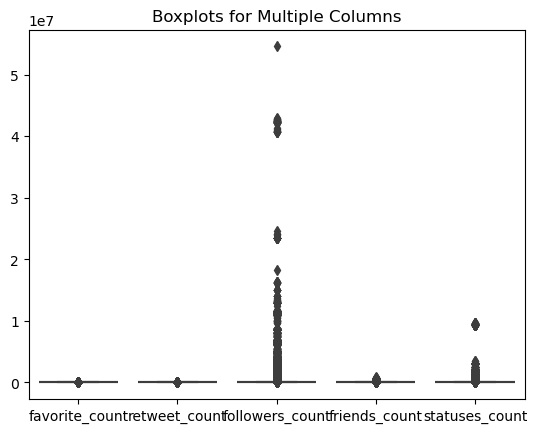

In [21]:
# Checking for outliers
sns.boxplot(data=metoo_df[["favorite_count", "retweet_count", "followers_count", "friends_count", "statuses_count"]])
plt.title("Boxplots for Multiple Columns")
plt.show()

In [22]:
print(metoo_df.describe())

       favorite_count  retweet_count  followers_count  friends_count  \
count   666125.000000  666125.000000     6.661250e+05  666125.000000   
mean         7.376219       2.869937     3.654647e+04    1920.910350   
std        174.862113      55.320722     5.551589e+05   10747.303826   
min          0.000000       0.000000     0.000000e+00       0.000000   
25%          0.000000       0.000000     9.700000e+01     154.000000   
50%          0.000000       0.000000     4.650000e+02     477.000000   
75%          2.000000       1.000000     2.224000e+03    1468.000000   
max      70385.000000   17484.000000     5.457643e+07  899383.000000   

       statuses_count        Hateful  
count    6.661250e+05  666125.000000  
mean     3.207914e+04       0.131864  
std      1.340143e+05       0.338343  
min      1.000000e+00       0.000000  
25%      1.419000e+03       0.000000  
50%      6.651000e+03       0.000000  
75%      2.568000e+04       0.000000  
max      9.565126e+06       1.000000  


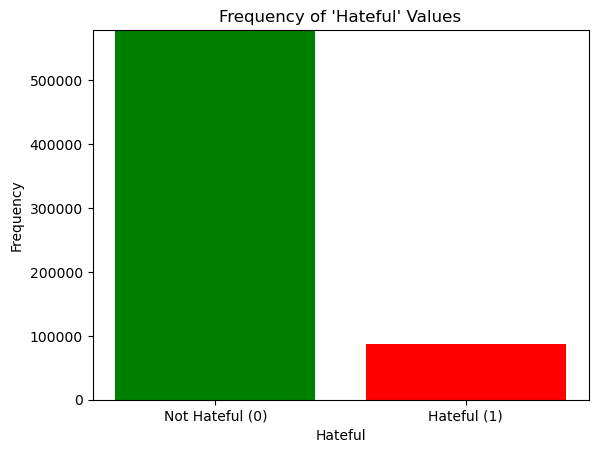

In [26]:
# Checking the distribution of the target variable
frequency = metoo_df["Hateful"].value_counts()
plt.bar(frequency.index, frequency.values, color=["green", "red"])
plt.title("Frequency of 'Hateful' Values")
plt.xlabel("Hateful")
plt.ylabel("Frequency")
plt.xticks(ticks=[0, 1], labels=["Not Hateful (0)", "Hateful (1)"])
plt.ylim(0, frequency.max() + 1)
plt.show()

In [27]:
# Bivariate Analysis
summary_data = metoo_df.groupby("Hateful").agg(
    mean_favorite_count=("favorite_count", "mean"),
    mean_retweet_count=("retweet_count", "mean"),
    mean_statuses_count=("statuses_count", "mean"),
    mean_followers_count=("followers_count", "mean"),
    mean_friends_count=("friends_count", "mean")
).reset_index()

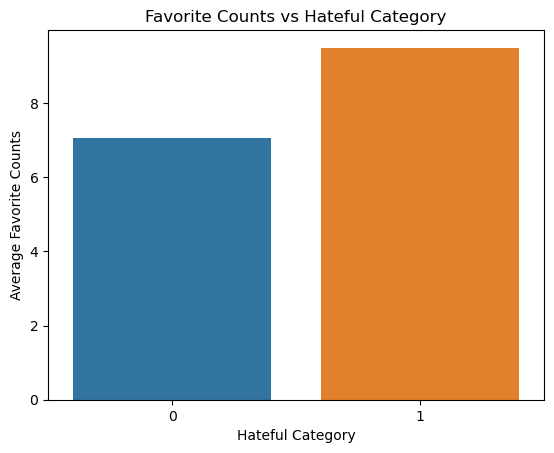

In [28]:
# Favorite counts vs Hateful
sns.barplot(x="Hateful", y="mean_favorite_count", data=summary_data)
plt.title("Favorite Counts vs Hateful Category")
plt.xlabel("Hateful Category")
plt.ylabel("Average Favorite Counts")
plt.show()

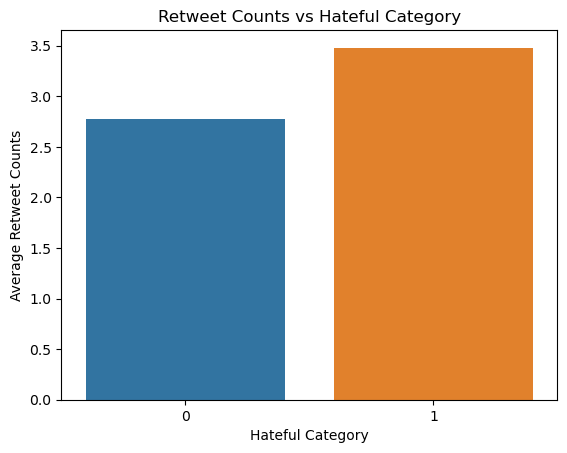

In [29]:
# Retweet counts vs Hateful
sns.barplot(x="Hateful", y="mean_retweet_count", data=summary_data)
plt.title("Retweet Counts vs Hateful Category")
plt.xlabel("Hateful Category")
plt.ylabel("Average Retweet Counts")
plt.show()

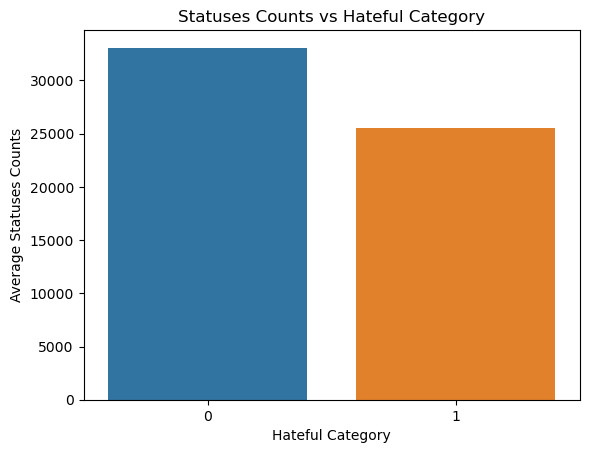

In [30]:
# Statuses counts vs Hateful
sns.barplot(x="Hateful", y="mean_statuses_count", data=summary_data)
plt.title("Statuses Counts vs Hateful Category")
plt.xlabel("Hateful Category")
plt.ylabel("Average Statuses Counts")
plt.show()

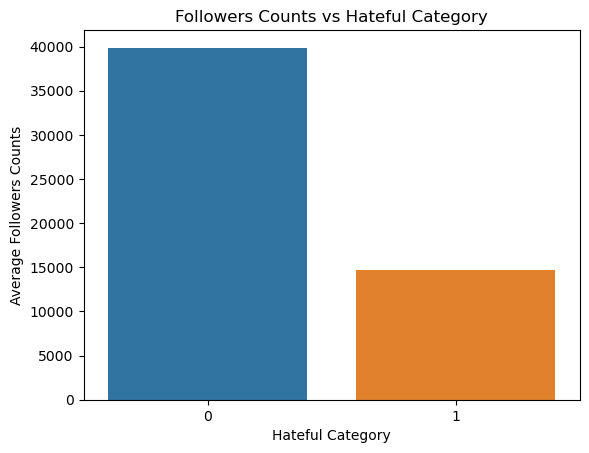

In [31]:
# Followers counts vs Hateful
sns.barplot(x="Hateful", y="mean_followers_count", data=summary_data)
plt.title("Followers Counts vs Hateful Category")
plt.xlabel("Hateful Category")
plt.ylabel("Average Followers Counts")
plt.show()


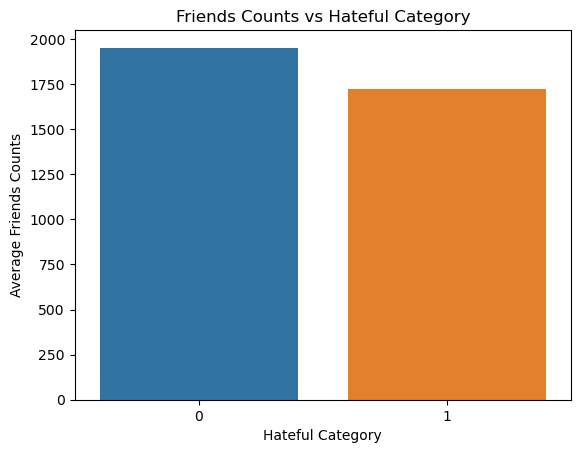

In [32]:

# Friends counts vs Hateful
sns.barplot(x="Hateful", y="mean_friends_count", data=summary_data)
plt.title("Friends Counts vs Hateful Category")
plt.xlabel("Hateful Category")
plt.ylabel("Average Friends Counts")
plt.show()

In [33]:
# Assuming Metoo_df_clean is your DataFrame and 'Hateful' is a column with categorical data
# Converting 'Hateful' from factor (categorical in R) to numeric
metoo_df['Hateful'] = pd.to_numeric(metoo_df['Hateful'].astype('category').cat.codes)


In [34]:
# Selecting only the numerical columns for correlation analysis
numerical_data = metoo_df[['favorite_count', 'retweet_count', 'statuses_count', 'followers_count', 'friends_count', 'Hateful']]


In [35]:
# Compute the correlation matrix
cor_matrix = numerical_data.corr(method='pearson')  # 'pearson' is the default method


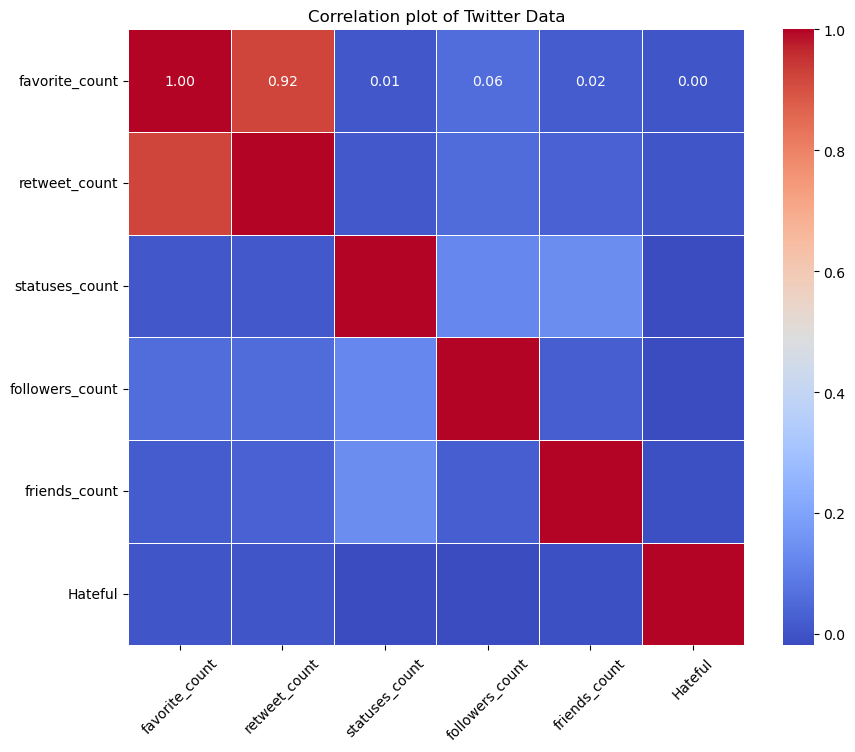

In [36]:
# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, square=True, linewidths=.5)
plt.title("Correlation plot of Twitter Data")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(metoo_df['processed_text'])


In [43]:
# Check the balance of the dataset
y = metoo_df['Hateful'].value_counts(normalize=True)
print(y)


Hateful
0    0.868136
1    0.131864
Name: proportion, dtype: float64


In [44]:
from imblearn.over_sampling import SMOTE

# Assuming df['category'] has been correctly loaded
y = metoo_df['Hateful'].astype(int)  # Ensuring y is of integer type

# Checking unique values in y to confirm it's suitable for classification
print("Unique categories in y:", y.unique())

# Proceed with feature extraction
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(metoo_df['processed_text'])

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


Unique categories in y: [0 1]


In [37]:
# Calculating the skewness between the variables
numerical_variables = metoo_df[['favorite_count', 'retweet_count', 'statuses_count', 'followers_count', 'friends_count']]
skew_values = numerical_variables.apply(lambda x: skew(x.dropna()))  # Applying skewness function to each column
print(skew_values)

favorite_count     188.303177
retweet_count      122.550005
statuses_count      41.785016
followers_count     41.386929
friends_count       34.668200
dtype: float64


In [39]:
# Proportion of each class in the dataset
hateful_proportions = hateful_counts / len(metoo_df)
print(hateful_proportions)

Hateful
0    0.868136
1    0.131864
Name: count, dtype: float64
